# Blackjack Simulator #
Simulate playing the game of Blackjack (aka Twenty-one)

Implements Blackjack rules and basic stratgey from https://en.wikipedia.org/wiki/Blackjack.  Does not consider doubling down or splitting hands.  Dealer stays on a soft 17.

The simulation produces a data file that is graphed following the simulation to display the player's and dealer's wins, busts, and pushes.


In [14]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

sims_to_run = 1  # change this value to run more of fewer sets of games
                 # note: a setting of '1' will produce a chart, more than one will produce a table of statistics
games_to_play = 100  # change this value to play more or fewer games
decks_in_shoe = 4  # number of decks of cards to hold in shoe
shoe_min_length = 10  # min number of cards in shoe before reload occurs

suits = ['H', 'D', 'S', 'C']
cards = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
shoedeck = []


In [17]:
def create_deck():
    """
    Create a list representing a deck of shuffled cards.  Individual cards are represented as suit followed by value:  
      H2 = two of hearts,
      S10 = ten of spades,
      DQ = queen of diamonds,
      CA = ace of clubs, etc.
      
      Returns
      -------
      card_deck : list - representing a shuffled deck of cards
    """
    card_deck = []
    
    # create deck of cards
    for suit in suits:
        for card in cards:
            card_deck.append(suit + card)
    random.seed()        
    random.shuffle(card_deck)
    return card_deck
  

def create_shoe(num_decks):
    """
    Create a shoe containing num_decks of decks of cards.  Cut the shoe.
    
    Parameters
    ----------
    num_decks : int - number of deck of cards to put in the shoe
    
    Returns
    -------
    shoe : list - shuffled and cut master deck of cards to deal from
    """
    shoe = []
    top_shoe = []
    bottom_shoe = []
    i = 0
    while i in range(0, num_decks):
        shoe.extend(create_deck())
        i += 1
        
    # cut shoe
    random.seed()
    cut_card = random.randint(0, len(shoe) - 1)
    shoe = shoe[cut_card:] + shoe[:cut_card] 
    return shoe    
    

def reload_shoe(hand1, hand2):
    """
    Create a new shoe and remove cards that are already in play
    
    Parameters
    ----------
    hand1, hand2 : lists - representing played cards for player and dealer
    
    Returns
    -------
    shoe : list - shuffled and cut master deck of cards to deal from, minus the first occurnaces of the cards in play
    """    
    print('reloading shoe...')
    shoe = create_shoe(decks_in_shoe)
    cards_in_play = hand1 + hand2
    print('removing cards in play: ', cards_in_play)
    
    for card in cards_in_play:
        if card in shoe: 
            shoe.remove(card)   
    return shoe


def check_for_blackjack(hand):
    """
    Checks for a blackjack (ace and a face card or 10)
    
    Parameters
    ----------
    hand : list - player's hand of cards to check
    
    Returns
    -------
    true / false
    
    """
    face_card = False
    ace = False
    
    if len(hand) == 2:
        for card in hand:
            card_pos = cards.index(str(card)[1:])
            # Face cards & 10
            if 7 < card_pos < 12:
                face_card = True
            if card_pos == 12:
                ace = True
    return face_card and ace


def score_hand(hand):
    """
    Calculates the score for the hand.  If aces are included (soft score), the best score is returned.
    Considers hands with multiple aces where one ace is scored as 11 and the other one.
    
    Parameters
    ----------
    hand : list - player's hand of cards to check
    
    Returns
    -------
    score : int - the score of the hand
    """
    
    hard_score = 0
    soft_score = 0
    score = 0
    ace_count = 0
    combo_score = 0
    
    for card in hand:
        card_pos = cards.index(str(card)[1:])
        # Face cards & 10
        if 7 < card_pos < 12:
            hard_score += 10
            soft_score += 10
            combo_score += 10
        # Ace    
        elif card_pos == 12:
            hard_score += 11
            soft_score += 1
            ace_count += 1
            
            # check for two aces in hand.  This would be split in real life.
            if ace_count > 1:
                combo_score = soft_score + 10
                
        # all other cards    
        else:
            hard_score += int(cards[card_pos])
            soft_score += int(cards[card_pos])
            combo_score += int(cards[card_pos])
            
    if hard_score > 21:
        score = soft_score
    elif hard_score > soft_score:
        score = hard_score
    else:
        score = soft_score

    # check if combo score needs to be returned
    if score < combo_score < 21:
        score = combo_score         
    return score


def play_dealer(hand, deck):
    """
    Dealer simply hits on <16 and stays on >=17.
    
    Parameters
    ----------
    hand : list - player's hand of cards to check
    deck : list - the shoe of cards from which to deal hits
    
    Returns
    -------
    hand : list - updated hand of cards
    score : int - the score of the hand
    
    """  
    while score_hand(hand) < 17:
        hand.append(deck.pop())
        print('  dealer hand after hit ', hand,' = ', score_hand(hand))
    
    print('dealer hand final ', hand,' = ', score_hand(hand))   
    return hand, score_hand(hand)


def play_player(hand, dealer_card, deck):
    """
    Implements Blackjack Basic Stratgey Chart from https://www.blackjackapprenticeship.com/blackjack-strategy-charts
    Does not consider doubling down or splitting hands.
    
    Parameters
    ----------
    hand : list - player's hand of cards to check
    dealer_card : string - the dealer's showing card (the first card in thier hand)
    deck : list - the shoe of cards from which to deal hits
    
    Returns
    -------
    hand : list - updated hand of cards
    score : int - the score of the hand
    """
    stay = False
    soft = False

    # soft scores (i.e., an Ace is involved)
    # does not consider doubling bet or splitting hands
    for ace in ['SA', 'DA', 'CA', 'HA']:
        if ace in hand:
            soft = True
            
    if soft:        
        while not stay:
            score = score_hand(hand)
            if score < 17:
                hand.append(deck.pop())
                print('  (soft) player hand after hit ', hand, ' = ', score_hand(hand))
            elif score == 17 and dealer_card[1:] in ['2', '3', '4', '5' ,'6', '7', '8']:
                stay = True
            elif score == 17 and dealer_card[1:] in ['9', '10', 'J', 'Q', 'K', 'A']:
                hand.append(deck.pop())
                print('  (soft) player hand after hit ', hand, ' = ', score_hand(hand))
            else:
                stay = True
            
    else:
        # hard scores only
        # does not consider doubling bet or splitting hands
        while not stay:
            score = score_hand(hand)
            if score < 12:
                hand.append(deck.pop())
                print('  player hand after hit ', hand, ' = ', score_hand(hand))
            elif score == 12 and dealer_card[1:] in ['2', '3', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']:
                hand.append(deck.pop())
                print('  player hand after hit ', hand, ' = ', score_hand(hand))
            elif score == 12 and dealer_card[1:] in ['4', '5', '6']:
                stay = True
            elif 12 < score < 17 and dealer_card[1:] in ['7', '8', '9', '10', 'J', 'Q', 'K', 'A']:
                hand.append(deck.pop())
                print('  player hand after hit ', hand, ' = ', score_hand(hand))
            elif 12 < score < 17 and dealer_card[1:] in ['2', '3', '4', '5', '6']:
                stay = True
            else:
                stay = True
            
    print('player hand final ', hand,' = ', score_hand(hand))       
    return hand, score_hand(hand)


def write_to_datafile(f, data):
    """
    Write data to CSV file for processing
    
    Parameters
    ----------
    data : dict - game_stat values
    
    """
    data_keys = ['game', 'dealer_hand_start', 'dealer_hand_final', 'dealer_score', 'dealer_bust', 'dealer_win', 'dealer_blackjack', 
                 'player_hand_start', 'player_hand_final', 'player_score', 'player_bust', 'player_win', 'player_blackjack', 
                 'push']
    for key in data_keys:
        if key in data:
            f.write('\"{}\"'.format(data[key]))
            if key != 'push':
                f.write(',')
        else:
            f.write('\"\",')
    f.write('\n')
    return


def plot_results(csv_file):

    # read data file
    data = pd.read_csv(csv_file)

    data['player_cum_win'] = data['player_win'].cumsum()
    data['dealer_cum_win'] = data['dealer_win'].cumsum()
    data['player_cum_bust'] = data['player_bust'].cumsum()
    data['dealer_cum_bust'] = data['dealer_bust'].cumsum()
    data['player_cum_blackjack'] = data['player_blackjack'].cumsum()
    data['dealer_cum_blackjack'] = data['dealer_blackjack'].cumsum()
    data['push_cum'] = data['push'].cumsum()

    # print stats
    print('\n\nGame stats')
    print('----------')
    print('Player Wins: {}/{} = {:.2f}'.format(data['player_win'].sum(), games_to_play, data['player_win'].sum() / games_to_play))
    print('Player Blackjack: {}/{} = {:.2f}'.format(data['player_blackjack'].sum(), games_to_play, data['player_blackjack'].sum() / games_to_play))
    print('Player Busts: {}/{} = {:.2f}'.format(data['player_bust'].sum(), games_to_play, data['player_bust'].sum() / games_to_play))
    print()
    print('Dealer Wins: {}/{} = {:.2f}'.format(data['dealer_win'].sum(), games_to_play, data['dealer_win'].sum() / games_to_play))
    print('Dealer Blackjack: {}/{} = {:.2f}'.format(data['dealer_blackjack'].sum(), games_to_play, data['dealer_blackjack'].sum() / games_to_play))
    print('Dealer Busts: {}/{} = {:.2f}'.format(data['dealer_bust'].sum(), games_to_play, data['dealer_bust'].sum() / games_to_play))
    print()
    print('Pushes: {}/{} = {:.2f}'.format(data['push'].sum(), games_to_play, data['push'].sum() / games_to_play))

    # make plot
    fig = plt.figure(figsize=(20,5))

    ax1 = fig.add_subplot(121)

    data.plot(kind='line',use_index=True,y='player_cum_win', color='blue', ax=ax1, 
              title='Blackjack Simulation ({} games)'.format(data.shape[0]))
    data.plot(kind='line',use_index=True,y='dealer_cum_win', color='red', ax=ax1)
    data.plot(kind='line',use_index=True,y='player_cum_bust', color='green', ax=ax1)
    data.plot(kind='line',use_index=True,y='dealer_cum_bust', color='yellow', ax=ax1)
    data.plot(kind='line', use_index=True,y='push_cum', color='black', ax=ax1)

    ax1.set_xlabel('Games Played')
    ax1.set_ylabel('Occurrences')
    ax1.legend(loc='upper left')

    plt.show();

    # save plot
    fig.savefig('bj-plot.jpg', dpi=fig.dpi)
    return


def run_simulation(csv_file):        
    # open output file
    f = open(csv_file, 'w')
    f.write('game,dealer_hand_start,dealer_hand_final,dealer_score,dealer_bust,dealer_win,dealer_blackjack,player_hand_start, ' +
            'player_hand_final,player_score,player_bust,player_win,player_blackjack,push\n')

    shoedeck = create_shoe(decks_in_shoe)
    i = 0

    print('\nSimulating {} games of Blackjack\n'.format(games_to_play))
    while i in range(0, games_to_play):
        i += 1
        player_hand = []
        dealer_hand = []
        player_score = 0
        dealer_score = 0
        busted = False
        blackjack = False

        # init game_stats structure
        game_stats = { 'game':i, 
                       'dealer_hand_start': [],
                       'dealer_hand_final': [],
                       'dealer_score': 0,
                       'dealer_bust': 0,
                       'dealer_win': 0,
                       'dealer_blackjack': 0,
                       'player_hand_start': [],
                       'player_hand_final': [],
                       'player_score': 0,
                       'player_bust': 0,
                       'player_win': 0,
                       'player_blackjack': 0,
                       'push': 0 }


        print('\n====== GAME', i, '======')
        # If shoe is low, create a new shoe before hand is started
        if len(shoedeck) < shoe_min_length:
            shoedeck = create_shoe(decks_in_shoe)

        # deal hands
        player_hand = [shoedeck.pop(), shoedeck.pop()]
        dealer_hand = [shoedeck.pop(), shoedeck.pop()]   

        print('player hand dealt=', player_hand,' = ', score_hand(player_hand))
        print('dealer hand dealt=', dealer_hand,' = ', score_hand(dealer_hand))

        game_stats['player_hand_start'].extend(player_hand)
        game_stats['dealer_hand_start'].extend(dealer_hand)
        
        # check for black jack
        if check_for_blackjack(player_hand):
            print('BLACKJACK! Player wins')
            blackjack = True
            game_stats['player_blackjack'] = 1
            game_stats['player_score'] = 21
            game_stats['player_win'] = 1
            game_stats['dealer_score'] = score_hand(dealer_hand)

        elif check_for_blackjack(dealer_hand):
            print('BLACKJACK! Dealer wins')
            blackjack = True
            game_stats['dealer_blackjack'] = 1
            game_stats['dealer_score'] = 21
            game_stats['dealer_win'] = 1
            game_stats['player_score'] = score_hand(player_hand)

        else:    
            # If shoe is low, reload the shoe before each player's turn
            if len(shoedeck) < shoe_min_length:
                shoedeck = reload_shoe(player_hand, dealer_hand)

            # Play player's hand
            player_hand, player_score = play_player(player_hand, dealer_hand[0], shoedeck)

            # Player bust?
            if player_score > 21:
                busted = True
                print('Player BUSTED ({})'.format(player_score))
                print('Dealer wins!')
                game_stats['dealer_win'] = 1
                game_stats['player_bust'] = 1
                game_stats['dealer_score'] = dealer_score
                game_stats['player_score'] = player_score
                game_stats['dealer_score'] = score_hand(dealer_hand)
            else:    
                if len(shoedeck) < shoe_min_length:
                    shoedeck = reload_shoe(player_hand, dealer_hand)

                # Play Dealer's hand
                dealer_hand, dealer_score = play_dealer(dealer_hand, shoedeck)
                
            # Dealer bust?    
            if dealer_score > 21:
                busted = True
                print('Dealer BUSTED ({})'.format(dealer_score))
                print('Player wins!')
                game_stats['player_win'] = 1
                game_stats['dealer_bust'] = 1
                game_stats['dealer_score'] = dealer_score
                game_stats['player_score'] = player_score

        if not busted and not blackjack:
            if player_score > dealer_score:
                print('Player wins! [{}>{}]'.format(player_score, dealer_score))
                game_stats['player_win'] = 1
                game_stats['dealer_score'] = dealer_score
                game_stats['player_score'] = player_score
            elif player_score == dealer_score:
                print('Push! [{}={}]'.format(player_score, dealer_score))
                game_stats['push'] = 1
                game_stats['dealer_score'] = dealer_score
                game_stats['player_score'] = player_score
            else:
                print('Dealer wins! [{}>{}]'.format(dealer_score, player_score))
                game_stats['dealer_win'] = 1
                game_stats['dealer_score'] = dealer_score
                game_stats['player_score'] = player_score

        #print('shoe=', shoedeck)
        game_stats['player_hand_final'].extend(player_hand)
        game_stats['dealer_hand_final'].extend(dealer_hand)
        write_to_datafile(f, game_stats)
    f.close()  
    return


def aggregate_results(csv_file_in, csv_file_out):
    
    # read data file
    data = pd.read_csv(csv_file_in)
    f = None
    
    # write sim run totals
    if os.path.exists(csv_file_out):
        f = open(csv_file_out, 'a')
    else:
        f = open(csv_file_out, 'w')   
        f.write('dealer_win,dealer_blackjack,dealer_bust,player_win,player_blackjack,player_bust,push\n')
    
    f.write('{},{},{},{},{},{},{}\n'.format(data['dealer_win'].sum(), 
                                            data['dealer_blackjack'].sum(), 
                                            data['dealer_bust'].sum(),
                                            data['player_win'].sum(), 
                                            data['player_blackjack'].sum(), 
                                            data['player_bust'].sum(),
                                            data['push'].sum())) 
    f.close()
    return


def output_results(csv_file):
    # read data file
    data = pd.read_csv(csv_file)
    
    print('\n\nAggregate results for {} simulations of {} games.'.format(sims_to_run, games_to_play))
    print('Dealer Wins : avg: {:.2f}  std: {:.2f}'.format(data['dealer_win'].mean(), data['dealer_win'].std()))
    print('Dealer Blackjacks : avg: {:.2f}  std: {:.2f}'.format(data['dealer_blackjack'].mean(), data['dealer_blackjack'].std()))
    print('Dealer Busts : avg: {:.2f}  std: {:.2f}'.format(data['dealer_bust'].mean(), data['dealer_bust'].std()))
    print()
    print('Player Wins : avg: {:.2f}  std: {:.2f}'.format(data['player_win'].mean(), data['player_win'].std()))
    print('Player Blackjacks : avg: {:.2f}  std: {:.2f}'.format(data['player_blackjack'].mean(), data['player_blackjack'].std()))
    print('Player Busts : avg: {:.2f}  std: {:.2f}'.format(data['player_bust'].mean(), data['player_bust'].std()))
    print()
    print('Pushes : avg: {:.2f}  std: {:.2f}'.format(data['push'].mean(), data['push'].std()))
    return
    


Simulating 100 games of Blackjack


====== GAME 1 ======
player hand dealt= ['S2', 'C7']  =  9
dealer hand dealt= ['SQ', 'S3']  =  13
  player hand after hit  ['S2', 'C7', 'HQ']  =  19
player hand final  ['S2', 'C7', 'HQ']  =  19
  dealer hand after hit  ['SQ', 'S3', 'S7']  =  20
dealer hand final  ['SQ', 'S3', 'S7']  =  20
Dealer wins! [20>19]

====== GAME 2 ======
player hand dealt= ['D3', 'DK']  =  13
dealer hand dealt= ['SJ', 'H7']  =  17
  player hand after hit  ['D3', 'DK', 'DA']  =  14
  player hand after hit  ['D3', 'DK', 'DA', 'S8']  =  22
player hand final  ['D3', 'DK', 'DA', 'S8']  =  22
Player BUSTED (22)
Dealer wins!

====== GAME 3 ======
player hand dealt= ['C8', 'D4']  =  12
dealer hand dealt= ['H9', 'D9']  =  18
  player hand after hit  ['C8', 'D4', 'S9']  =  21
player hand final  ['C8', 'D4', 'S9']  =  21
dealer hand final  ['H9', 'D9']  =  18
Player wins! [21>18]

====== GAME 4 ======
player hand dealt= ['H10', 'C4']  =  14
dealer hand dealt= ['C10', 'CA']  =  21
BLA

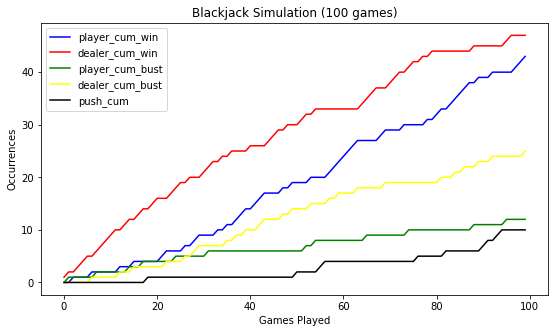

In [18]:
"""
Main processing loop
"""

if __name__=='__main__':
    
    if sims_to_run == 1:
        run_simulation('bj_sim.csv')
        plot_results('bj_sim.csv')
    else:
        if os.path.exists('bj_sim_cum.csv'):
            os.remove('bj_sim_cum.csv')
        for j in range(sims_to_run):
            run_simulation('bj_sim{}.csv'.format(j))
            aggregate_results('bj_sim{}.csv'.format(j), 'bj_sim_cum.csv')
            os.remove('bj_sim{}.csv'.format(j))
        output_results('bj_sim_cum.csv')
#<SDG><